## Datasets
- web : https://ieee-dataport.org/open-access/stock-market-tweets-data
- Submitted by:Bruno Taborda
- Twitter is one of the most popular social networks for sentiment analysis. This data set of tweets are related to the stock market. We collected 943,672 tweets between April 9 and July 16, 2020, using the S&P 500 tag (#SPX500), the references to the top 25 companies in the S&P 500 index, and the Bloomberg tag (#stocks). __1,300 out of the 943,672 tweets were manually annotated in positive, neutral, or negative classes.__ A second independent annotator reviewed the manually annotated tweets. This annotated data set can contribute to create new domain-specific lexicons or enrich some of the actual dictionaries. Researchers can train their supervised models using the annotated data set. Additionally, the full data set can be used for text mining and sentiment analysis related to the stock market.

## Embedding with DNN 

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import time
import nltk
from datetime import datetime
import collections
import re

# 상관계수
from scipy import stats

# model

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
import tensorflow

tensorflow.__version__

'2.6.0'

## I.데이터 불러오기 & 전처리

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!ls -l '/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/tweets_labelled_09042020_16072020.csv'

-rw------- 1 root root 959890 Nov  1 02:54 '/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/tweets_labelled_09042020_16072020.csv'


In [7]:
DF = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/cryptocurrency_sentiment/tweets_labelled_09042020_16072020.csv', sep= ';')
# DF = pd.read_csv('c:/My_data/health_care/cryptocurrency_sentiment/tweets_labelled_09042020_16072020.csv', sep= ';')
DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5000 non-null   int64 
 1   created_at  5000 non-null   object
 2   text        5000 non-null   object
 3   sentiment   1300 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB


In [8]:
# null 값 확인
DF.isnull().sum()


id               0
created_at       0
text             0
sentiment     3700
dtype: int64

In [9]:
#결측치 제거
DF.dropna(inplace = True)
DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1300 non-null   int64 
 1   created_at  1300 non-null   object
 2   text        1300 non-null   object
 3   sentiment   1300 non-null   object
dtypes: int64(1), object(3)
memory usage: 50.8+ KB


In [10]:
ticker_pattern = re.compile(r'(^\$[A-Z]+|^\$ES_F)')
ht_pattern = re.compile(r'#\w+')

ticker_dic = collections.defaultdict(int)
ht_dic = collections.defaultdict(int)

for text in DF['text']:
    for word in text.split():
        if ticker_pattern.fullmatch(word) is not None:
            ticker_dic[word[1:]] += 1
        
        word = word.lower()
        if ht_pattern.fullmatch(word) is not None:
            ht_dic[word] += 1

In [11]:
DF.head()

,id,created_at,text,sentiment
0,77522,2020-04-15 01:03:46+00:00,"RT @RobertBeadles: Yo💥\nEnter to WIN 1,000 Mon...",positive
1,661634,2020-06-25 06:20:06+00:00,#SriLanka surcharge on fuel removed!\n⛽📉\nThe ...,negative
2,413231,2020-06-04 15:41:45+00:00,Net issuance increases to fund fiscal programs...,positive
3,760262,2020-07-03 19:39:35+00:00,RT @bentboolean: How much of Amazon's traffic ...,positive
4,830153,2020-07-09 14:39:14+00:00,$AMD Ryzen 4000 desktop CPUs looking ‘great’ a...,positive


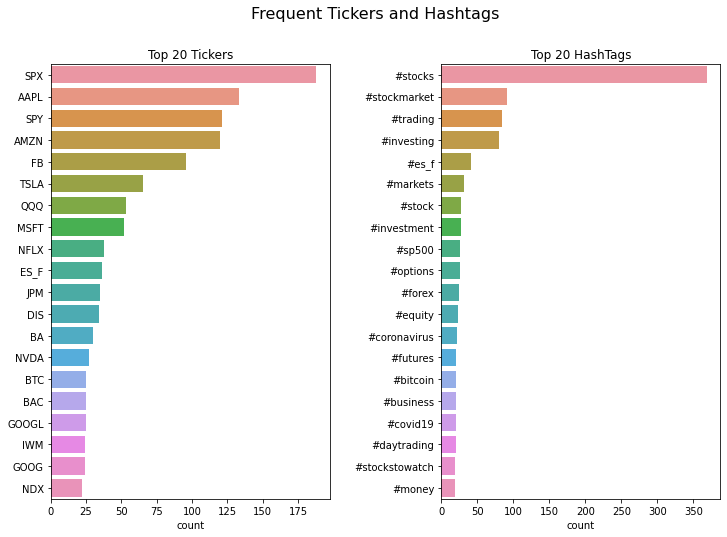

In [12]:
ticker_df = pd.DataFrame.from_dict(
    ticker_dic, orient='index').rename(columns={0:'count'})\
    .sort_values('count', ascending=False).head(20)
    
ht_df = pd.DataFrame.from_dict(
    ht_dic, orient='index').rename(columns={0:'count'})\
    .sort_values('count', ascending=False).head(20)

fig, ax = plt.subplots(1, 2, figsize=(12,8))
plt.suptitle('Frequent Tickers and Hashtags', fontsize=16)
plt.subplots_adjust(wspace=0.4)

sns.barplot(x=ticker_df['count'], y=ticker_df.index, orient='h', ax=ax[0])
ax[0].set_title('Top 20 Tickers')

sns.barplot(x=ht_df['count'], y=ht_df.index, orient='h', ax=ax[1])
ax[1].set_title('Top 20 HashTags')

plt.show()

In [13]:
charonly = re.compile(r'[^a-zA-Z\s]')
handle_pattern = re.compile(r'@\w+')
emoji_pattern = re.compile("["
                        u"\U0001F600-\U0001F64F"  # emoticons
                        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                        u"\U0001F680-\U0001F6FF"  # transport & map symbols
                        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        "]+", flags=re.UNICODE)
url_pattern = re.compile(
    'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
pic_pattern = re.compile('pic\.twitter\.com/.{10}')
special_code = re.compile(r'(&amp;|&gt;|&lt;)')
tag_pattern = re.compile(r'<.*?>')

STOPWORDS = set(stopwords.words('english')).union(
    {'rt', 'retweet', 'RT', 'Retweet', 'RETWEET'})

lemmatizer = WordNetLemmatizer()

def hashtag(phrase):
    return ht_pattern.sub(' ', phrase)

def remove_ticker(phrase):
    return ticker_pattern.sub('', phrase)
    
def specialcode(phrase):
    return special_code.sub(' ', phrase)

def emoji(phrase):
    return emoji_pattern.sub(' ', phrase)

def url(phrase):
    return url_pattern.sub('', phrase)

def pic(phrase):
    return pic_pattern.sub('', phrase)

def html_tag(phrase):
    return tag_pattern.sub(' ', phrase)

def handle(phrase):
    return handle_pattern.sub('', phrase)

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    
    # DIS, ticker symbol of Disney, is interpreted as the plural of "DI" 
    # in WordCloud, so I converted it to Disney
    phrase = re.sub('DIS', 'Disney', phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"(he|He)\'s", "he is", phrase)
    phrase = re.sub(r"(she|She)\'s", "she is", phrase)
    phrase = re.sub(r"(it|It)\'s", "it is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"(\'ve|has)", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def onlychar(phrase):
    return charonly.sub('', phrase)

def remove_stopwords(phrase):
    return " ".join([word for word in str(phrase).split()\
                     if word not in STOPWORDS])

def tokenize_stem(phrase):   
    tokens = word_tokenize(phrase)
    stem_words =[]
    for token in tokens:
        word = lemmatizer.lemmatize(token)
        stem_words.append(word)        
    buf = ' '.join(stem_words)    
    return buf

In [14]:
def arrange_text(ds):
    ds['text2'] = ds['text'].apply(emoji)
    ds['text2'] = ds['text2'].apply(handle)
    ds['text2'] = ds['text2'].apply(specialcode)
    ds['text2'] = ds['text2'].apply(hashtag)
    ds['text2'] = ds['text2'].apply(url)
    ds['text2'] = ds['text2'].apply(pic)
    ds['text2'] = ds['text2'].apply(html_tag)
    ds['text2'] = ds['text2'].apply(onlychar)
    ds['text2'] = ds['text2'].apply(decontracted)
    ds['text2'] = ds['text2'].apply(onlychar)
    ds['text2'] = ds['text2'].apply(tokenize_stem)
    ds['text2'] = ds['text2'].apply(remove_stopwords)

In [17]:
words = ' '.join([text for text in data['text2']])
wordcloud = WordCloud(
    width=800, height=400, background_color='white', max_font_size=110)\
    .generate(words)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.title('Words in all tweet\n', fontsize=24)
plt.axis('off')
plt.show()

NameError: ignored